In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import time

### Model for MNIST

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.ConvTranspose2d(74, 1024, 1, 1)
    self.bn1 = nn.BatchNorm2d(1024) 

    self.fc2 = nn.ConvTranspose2d(1024, 128, 7, 1)
    self.bn2 = nn.BatchNorm2d(128)

    self.upconv3 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1)
    self.bn3 = nn.BatchNorm2d(64)

    self.upconv4 = nn.ConvTranspose2d(64, 1, 4, 2, padding=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.bn1(x)
    x = F.relu(x)


    x = self.fc2(x)
    x = self.bn2(x)
    x = F.relu(x)

    x = self.upconv3(x)
    x = self.bn3(x)
    x = F.relu(x)

    x = F.tanh(self.upconv4(x))

    return x

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)

    self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
    self.bn2 = nn.BatchNorm2d(128)

    self.fc3 = nn.Conv2d(128, 1024, 7)
    self.bn3 = nn.BatchNorm2d(1024)

  def forward(self, x):

    x = F.leaky_relu(self.conv1(x), 0.1)
    x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
    x = F.leaky_relu(self.bn3(self.fc3(x)), 0.1)

    return x

In [ ]:
class DiscriminatorHead(nn.Module):
  def __init__(self):
    #input: smth
    #output: number
    super().__init__()
    self.fc = nn.Conv2d(1024, 1, 1)

  def forward(self, x):
    x = torch.sigmoid(self.fc(x))
    return x

In [ ]:
class QHead(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Conv2d(1024, 128, 1)
    self.bn1 = nn.BatchNorm2d(128)

    # 10 as probs of values to discrete params
    self.fc2 = nn.Conv2d(128, 10, 1)
    
    #for Gaussian - contin. noise parameters
    self.conv_mu = nn.Conv2d(128, 2, 1)
    self.conv_var = nn.Conv2d(128, 2, 1)

  def forward(self, x):
    #discrete. softmax will be under loss function
    x = F.leaky_relu(self.bn1(self.fc1(x)), 0.1)
    y = self.fc2(x).squeeze()

    #2 cont params are gaussuians    
    mu = self.conv_mu(x).squeeze()
    var = torch.exp(self.conv_var(x).squeeze())
    return y, mu, var

In [ ]:
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [ ]:
transform = transforms.Compose([transforms.Resize(28), transforms.CenterCrop(28), transforms.ToTensor()])
dataset = datasets.MNIST('data/mnist/', train='train', download=True, transform=transform)

In [ ]:
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
head_disc = DiscriminatorHead().to(device)
head_q = QHead().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)
head_disc.apply(weights_init)
head_q.apply(weights_init)

QHead(
  (fc1): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv_mu): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
  (conv_var): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
def GaussianLoss(x, mu, var):
    #for con. code, eps for numerical stability (logp(x))
    eps = 1e-6
    return ((1/2 * torch.log(2 * torch.pi * var + eps) + ((x - mu)**2)/(2 * var + eps)).sum(axis = 1)).mean()

In [ ]:
criterionD = nn.BCELoss() #classic
criterionQ_dis = nn.CrossEntropyLoss() #because of using softmax

In [ ]:
#lr from paper, betas from other implementations
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': head_disc.parameters()}], lr=2e-4, betas=(0.5, 0.999))
optimG = optim.Adam([{'params': generator.parameters()}, {'params': head_q.parameters()}], lr=1e-3, betas=(0.5, 0.999))

In [ ]:
fixed_noise = torch.randn(100, 62, 1, 1, device=device) #noise variables
con = torch.rand(100, 2, 1, 1, device=device) * 2 - 1 #from -1 to 1
x = np.arange(10).repeat(10)
dis = torch.zeros(100, 1, 10, device=device)
dis[torch.arange(100), 0, x] = 1 
dis = dis.view(100, -1, 1, 1)
fixed_noise = torch.cat((fixed_noise, dis, con), dim=1)

In [ ]:
images = []
G_losses = []
D_losses = []

num_epochs = 100

In [ ]:
#preparing for celebA and chairs
def noise_function(n_dis, dis_dim, n_con, num_z, batch_size, device):
    z = torch.randn(batch_size, num_z, 1, 1, device=device)

    idx = np.zeros((n_dis, batch_size))
    idx[0] = np.random.randint(dis_dim, size=batch_size)
    
    dis = torch.zeros(batch_size, n_dis, dis_dim, device=device)
    dis[torch.arange(0, batch_size), 0, idx[0]] = 1.0
    dis = dis.view(batch_size, -1, 1, 1)
    
    con = torch.rand(batch_size, n_con, 1, 1, device=device) * 2 - 1
    noise = torch.cat((z, dis, con), dim=1)

    return noise, idx

In [ ]:
for epoch in range(num_epochs):
    for i, (batch, _) in enumerate(dataloader, 0):
        
        batch_size = batch.size(0)

        #discriminator
        optimD.zero_grad()
        label = torch.full((batch.size(0), ), 1, device=device)
        output_real = discriminator(batch.to(device))
        probs_real = head_disc(output_real).view(-1)
        loss_real = criterionD(probs_real.to(torch.float32), label.to(torch.float32))
        loss_real.backward()
        label.fill_(0)
        noise, idx = noise_function(1, 10, 2, 62, batch.size(0), device)
        data_from_noise = generator(noise)
        probs_noise = head_disc(discriminator(data_from_noise.detach())).view(-1)
        loss_noise = criterionD(probs_noise.to(torch.float32), label.to(torch.float32))
        loss_noise.backward()
        D_loss = loss_real + loss_noise
        optimD.step()

        #generator
        optimG.zero_grad()
        output_noise = discriminator(data_from_noise)
        label.fill_(1)
        probs_noise = head_disc(output_noise).view(-1)
        generator_loss = criterionD(probs_noise.to(torch.float32), label.to(torch.float32))
        q_logits, q_mu, q_var = head_q(output_noise)
        target = torch.LongTensor(idx).to(device)
        dis_loss = criterionQ_dis(q_logits, target[0])
        con_loss = GaussianLoss(noise[:, 72: ].view(-1, 2), q_mu, q_var)/10

        #lambda = 1
        G_loss = generator_loss + dis_loss + con_loss
        G_loss.backward()
        optimG.step()

        if i == 200:
            print('epoch {} of {}\nLoss_D:{} \tLoss_G: {}'.format(epoch+1, num_epochs, D_loss.item(), G_loss.item()))
                 
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

    
    with torch.no_grad():
        gen_data = generator(fixed_noise).detach().cpu()
    images.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1 of 100
Loss_D:1.0444984436035156 	Loss_G: 1.061349630355835
epoch 2 of 100
Loss_D:1.0162570476531982 	Loss_G: 1.0705593824386597
epoch 3 of 100
Loss_D:1.0580416917800903 	Loss_G: 1.0626304149627686
epoch 4 of 100
Loss_D:1.1501750946044922 	Loss_G: 1.0109758377075195
epoch 5 of 100
Loss_D:1.118912935256958 	Loss_G: 1.1542357206344604
epoch 6 of 100
Loss_D:1.0783647298812866 	Loss_G: 0.9631931781768799
epoch 7 of 100
Loss_D:1.0087394714355469 	Loss_G: 0.9031221270561218
epoch 8 of 100
Loss_D:1.0359218120574951 	Loss_G: 1.0842329263687134
epoch 9 of 100
Loss_D:1.0768747329711914 	Loss_G: 1.1046783924102783
epoch 10 of 100
Loss_D:1.0070209503173828 	Loss_G: 1.2140077352523804
epoch 11 of 100
Loss_D:0.9228521585464478 	Loss_G: 1.325524091720581
epoch 12 of 100
Loss_D:0.9769003391265869 	Loss_G: 1.0380558967590332
epoch 13 of 100
Loss_D:0.8965739011764526 	Loss_G: 1.114681363105774
epoch 14 of 100
Loss_D:0.8626728653907776 	Loss_G: 1.5270801782608032
epoch 15 of 100
Loss_D:0.80849719

Проверяем, как работает генератор:

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


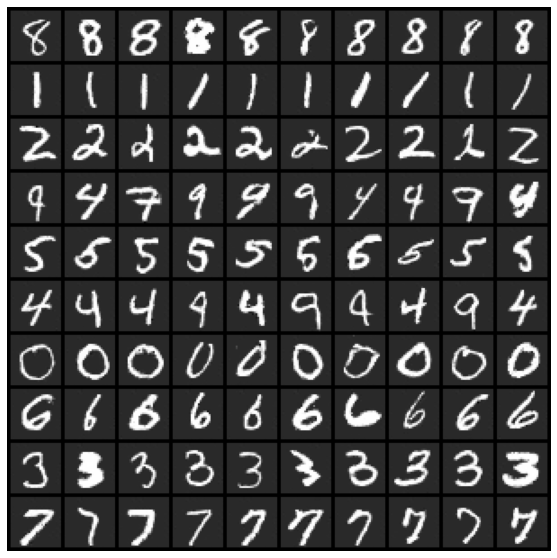

In [ ]:
with torch.no_grad():
    gen_data = generator(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))

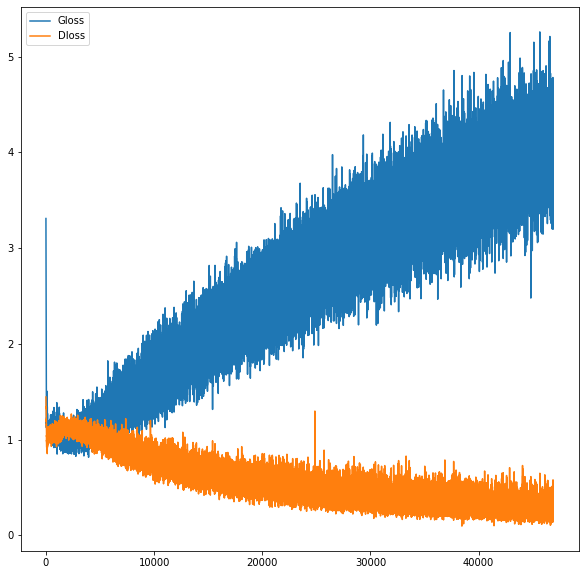

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(G_losses, label = 'Gloss')
plt.plot(D_losses, label = 'Dloss')
plt.legend()
plt.show()

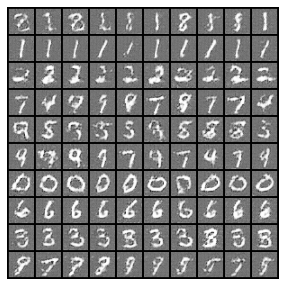

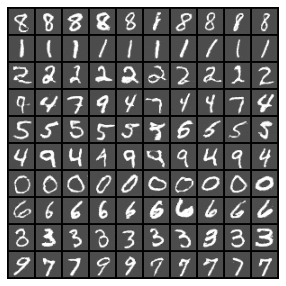

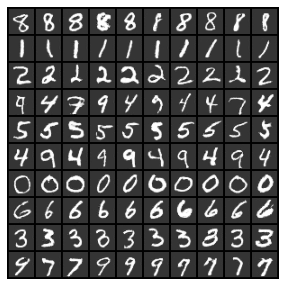

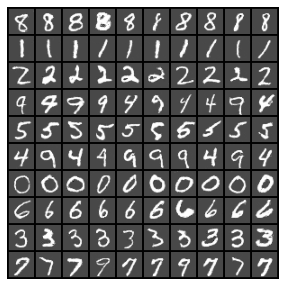

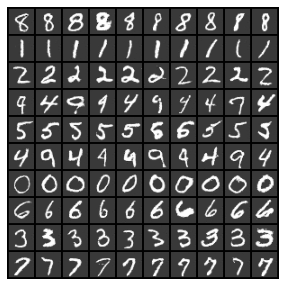

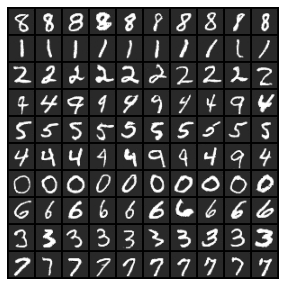

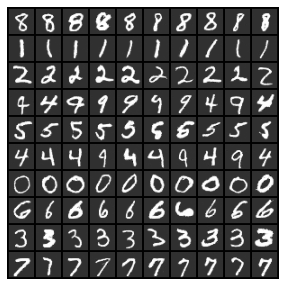

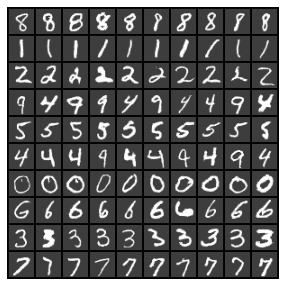

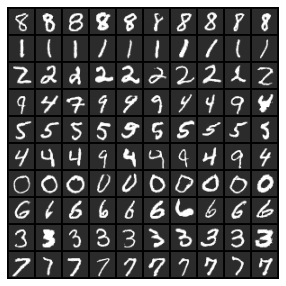

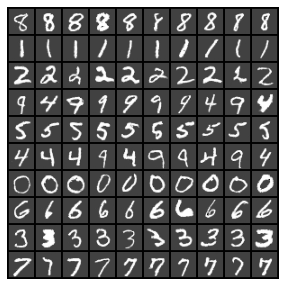

In [ ]:
for i in range(num_epochs//10):
  plt.figure(figsize=(5, 5))
  plt.imshow(np.transpose(images[i*10], (1, 2, 0)))
  plt.axis("off")
  plt.show()

Пробуем разные переменные

In [ ]:
fixed_noise_ = torch.randn(100, 62, 1, 1, device=device)

con1 = (((torch.arange(10, device=device).repeat(10))/9 - 1/2)*4).view(100, 1, 1, 1)
#con1 = (torch.arange(100, device=device)/25 - 2).view(100, -1, 1, 1)  #from -2 to 2
con2 = torch.rand(100, 1, 1, 1, device=device)
x_ = np.arange(10).repeat(10)
dis_ = torch.zeros(100, 1, 10, device=device)
dis_[torch.arange(100), 0, x_] = 1 
dis_ = dis_.view(100, -1, 1, 1)
fixed_noise_ = torch.cat((fixed_noise_, dis_, con1, con2), dim=1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


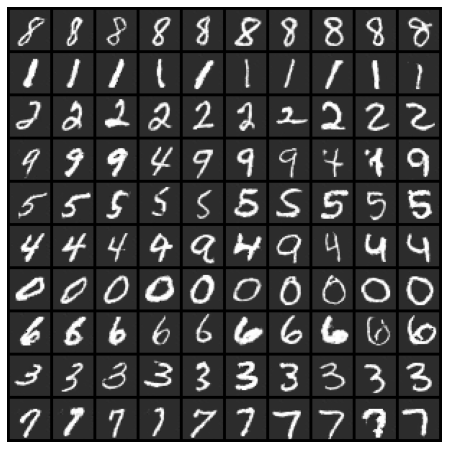

In [ ]:
with torch.no_grad():
  gen_data = generator(fixed_noise_).detach().cpu()
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))

Обратите внимание на наклон! Он разный и как раз меняется в одном направлении для всех строк

In [ ]:
fixed_noise_ = torch.randn(100, 62, 1, 1, device=device)

con2 = (((torch.arange(10, device=device).repeat(10))/9 - 1/2)*4).view(100, 1, 1, 1)
con1 = torch.zeros(100, 1, 1, 1, device=device)
x_ = np.arange(10).repeat(10)
dis_ = torch.zeros(100, 1, 10, device=device)
dis_[torch.arange(100), 0, x_] = 1 
dis_ = dis_.view(100, -1, 1, 1)
fixed_noise_ = torch.cat((fixed_noise_, dis_, con1, con2), dim=1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


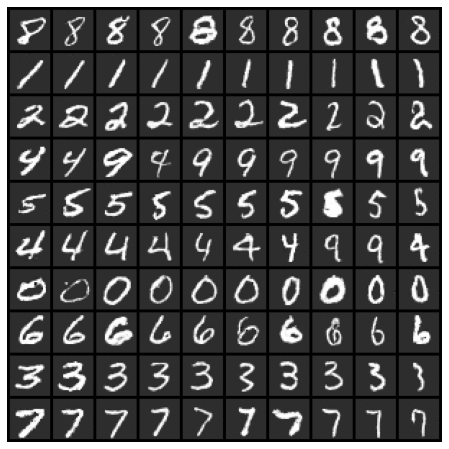

In [ ]:
with torch.no_grad():
  gen_data = generator(fixed_noise_).detach().cpu()
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))

А вот со второй непрерывной величиной нам не так повезло - простую интерпретацию придумать сложно. Могу лишь предположить, что меняется "размашистость почерка" - слева более размашистый, справа более "петельный". 

Тем не менее, одна из непрерывных переменных отвечает за наклон, а дискретные - за значение чисел (по строкам значения совпадают), а это уже неплохой результат.

#### Попробуем изменить количество "информационных" переменных

In [ ]:
class QHead(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Conv2d(1024, 128, 1)
    self.bn1 = nn.BatchNorm2d(128)

    # 10 as probs of values to discrete params
    self.fc2 = nn.Conv2d(128, 10, 1)
    
    #for Gaussian - contin. noise parameters
    self.conv_mu = nn.Conv2d(128, 3, 1)
    self.conv_var = nn.Conv2d(128, 3, 1)

  def forward(self, x):
    #discrete. softmax will be under loss function
    x = F.leaky_relu(self.bn1(self.fc1(x)), 0.1)
    y = self.fc2(x).squeeze()

    #2 cont params are gaussuians    
    mu = self.conv_mu(x).squeeze()
    var = torch.exp(self.conv_var(x).squeeze())
    return y, mu, var

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
head_disc = DiscriminatorHead().to(device)
head_q = QHead().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)
head_disc.apply(weights_init)
head_q.apply(weights_init)

QHead(
  (fc1): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv_mu): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
  (conv_var): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
criterionD = nn.BCELoss() #classic
criterionQ_dis = nn.CrossEntropyLoss() #because of using softmax

In [ ]:
#lr from paper, betas from other implementations
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': head_disc.parameters()}], lr=2e-4, betas=(0.5, 0.999))
optimG = optim.Adam([{'params': generator.parameters()}, {'params': head_q.parameters()}], lr=1e-3, betas=(0.5, 0.999))

In [ ]:
#зафиксируем один шумомой вектор, чтобы на нем проверять качество 
fixed_noise = torch.randn(100, 61, 1, 1, device=device) #noise variables
con = torch.rand(100, 3, 1, 1, device=device) * 2 - 1 #from -1 to 1
x = np.arange(10).repeat(10)
dis = torch.zeros(100, 1, 10, device=device)
dis[torch.arange(100), 0, x] = 1 
dis = dis.view(100, -1, 1, 1)
fixed_noise = torch.cat((fixed_noise, dis, con), dim=1)

In [ ]:
images = []
G_losses = []
D_losses = []

num_epochs = 100

In [ ]:
for epoch in range(num_epochs):
    for i, (batch, _) in enumerate(dataloader, 0):
        
        batch_size = batch.size(0)

        #discriminator
        optimD.zero_grad()
        label = torch.full((batch.size(0), ), 1, device=device)
        output_real = discriminator(batch.to(device))
        probs_real = head_disc(output_real).view(-1)
        loss_real = criterionD(probs_real.to(torch.float32), label.to(torch.float32))
        loss_real.backward()
        label.fill_(0)
        noise, idx = noise_function(1, 10, 2, 62, batch.size(0), device)
        data_from_noise = generator(noise)
        probs_noise = head_disc(discriminator(data_from_noise.detach())).view(-1)
        loss_noise = criterionD(probs_noise.to(torch.float32), label.to(torch.float32))
        loss_noise.backward()
        D_loss = loss_real + loss_noise
        optimD.step()

        #generator
        optimG.zero_grad()
        output_noise = discriminator(data_from_noise)
        label.fill_(1)
        probs_noise = head_disc(output_noise).view(-1)
        generator_loss = criterionD(probs_noise.to(torch.float32), label.to(torch.float32))
        q_logits, q_mu, q_var = head_q(output_noise)
        target = torch.LongTensor(idx).to(device)
        dis_loss = criterionQ_dis(q_logits, target[0])
        con_loss = GaussianLoss(noise[:, 72: ].view(-1, 2), q_mu, q_var)/10

        #lambda = 1
        G_loss = generator_loss + dis_loss + con_loss
        G_loss.backward()
        optimG.step()

        if i == 200:
            print('epoch {} of {}\nLoss_D:{} \tLoss_G: {}'.format(epoch+1, num_epochs, D_loss.item(), G_loss.item()))
                 
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

    
    with torch.no_grad():
        gen_data = generator(fixed_noise).detach().cpu()
    images.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1 of 100
Loss_D:1.0444984436035156 	Loss_G: 1.061349630355835
epoch 2 of 100
Loss_D:1.0162570476531982 	Loss_G: 1.0705593824386597
epoch 3 of 100
Loss_D:1.0580416917800903 	Loss_G: 1.0626304149627686
epoch 4 of 100
Loss_D:1.1501750946044922 	Loss_G: 1.0109758377075195
epoch 5 of 100
Loss_D:1.118912935256958 	Loss_G: 1.1542357206344604
epoch 6 of 100
Loss_D:1.0783647298812866 	Loss_G: 0.9631931781768799
epoch 7 of 100
Loss_D:1.0087394714355469 	Loss_G: 0.9031221270561218
epoch 8 of 100
Loss_D:1.0359218120574951 	Loss_G: 1.0842329263687134
epoch 9 of 100
Loss_D:1.0768747329711914 	Loss_G: 1.1046783924102783
epoch 10 of 100
Loss_D:1.0070209503173828 	Loss_G: 1.2140077352523804
epoch 11 of 100
Loss_D:0.9228521585464478 	Loss_G: 1.325524091720581
epoch 12 of 100
Loss_D:0.9769003391265869 	Loss_G: 1.0380558967590332
epoch 13 of 100
Loss_D:0.8965739011764526 	Loss_G: 1.114681363105774
epoch 14 of 100
Loss_D:0.8626728653907776 	Loss_G: 1.5270801782608032
epoch 15 of 100
Loss_D:0.80849719

Теперь попробуем то же с целебой.

### CelebA

In [ ]:
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset

data_root = 'data/celeba'
dataset_folder = f'{data_root}/img_align_celeba'
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
download_path = f'{data_root}/img_align_celeba.zip'

if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

## Create a custom Dataset class
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img

## Load the dataset 
# Path to directory with all the images
img_folder = f'{dataset_folder}/img_align_celeba'
# Spatial size of training images, images are resized to this size.
image_size = 32
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])
# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, transform)

## Create a dataloader 
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:15<00:00, 91.4MB/s]


In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.ConvTranspose2d(228, 428, 2, 1)
    self.bn1 = nn.BatchNorm2d(428) 

    self.fc2 = nn.ConvTranspose2d(428, 256, 4, 2, 1)
    self.bn2 = nn.BatchNorm2d(256)

    self.upconv3 = nn.ConvTranspose2d(256, 128, 4, 2, padding=1)
    
    self.upconv4 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1)
    self.upconv5 = nn.ConvTranspose2d(64, 3, 4, 2, padding=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.bn1(x)
    x = F.relu(x)

    x = self.fc2(x)
    x = self.bn2(x)
    x = F.relu(x)

    x = self.upconv3(x)
    x = F.relu(x)

    x = self.upconv4(x)
    x = F.relu(x)

    x = F.tanh(self.upconv5(x))

    return x

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)

    self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
    self.bn2 = nn.BatchNorm2d(128)

    self.fc3 = nn.Conv2d(128, 256, 4, 2, 1)
    self.bn3 = nn.BatchNorm2d(256)

  def forward(self, x):

    x = F.leaky_relu(self.conv1(x), 0.1)

    x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
    
    x = F.leaky_relu(self.bn3(self.fc3(x)), 0.1)

    return x

In [ ]:
class DiscriminatorHead(nn.Module):
  def __init__(self):
    #input: smth
    #output: number
    super().__init__()
    self.fc = nn.Conv2d(256, 1, 4)

  def forward(self, x):
    x = torch.sigmoid(self.fc(x))
    return x

In [ ]:
class QHead(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Conv2d(256, 128, 4, 1)
    self.bn1 = nn.BatchNorm2d(128)

    # 10 as probs of values to discrete params
    self.fc2 = nn.Conv2d(128, 10*10, 1)

  def forward(self, x):
    #discrete. softmax will be under loss function
    x = F.leaky_relu(self.bn1(self.fc1(x)), 0.1)
    x = self.fc2(x).squeeze()

    return x

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
head_disc = DiscriminatorHead().to(device)
head_q = QHead().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)
head_disc.apply(weights_init)
head_q.apply(weights_init)

QHead(
  (fc1): Conv2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Conv2d(128, 100, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
criterionD = nn.BCELoss() #classic
criterionQ_dis = nn.CrossEntropyLoss() #because of using softmax

In [ ]:
#lr from paper, betas from other implementations
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': head_disc.parameters()}], lr=2e-4, betas=(0.5, 0.999))
optimG = optim.Adam([{'params': generator.parameters()}, {'params': head_q.parameters()}], lr=1e-3, betas=(0.5, 0.999))

In [ ]:
fixed_noise = torch.randn(100, 128, 1, 1, device=device) #noise variables
x = np.arange(10).repeat(10)
dis = torch.zeros(100, 10, 10, device=device)
for i in range(10):
  dis[torch.arange(100), i, x] = 1 
dis = dis.view(100, -1, 1, 1)
fixed_noise = torch.cat((fixed_noise, dis), dim=1)

In [ ]:
images = []
G_losses = []
D_losses = []

num_epochs = 50

In [ ]:
#noise generator
def noise_function(n_dis, dis_dim, num_z, batch_size, device):
    z = torch.randn(batch_size, num_z, 1, 1, device=device)

    idx = np.zeros((n_dis, batch_size))
    dis = torch.zeros(batch_size, n_dis, dis_dim, device=device)
    for i in range(n_dis):
      idx[i] = np.random.randint(dis_dim, size=batch_size)
      dis[torch.arange(0, batch_size), i, idx[i]] = 1.0
    
    dis = dis.view(batch_size, -1, 1, 1)
    
    noise = torch.cat((z, dis), dim=1)

    return noise, idx

Nothing works :(

In [ ]:
for epoch in range(num_epochs):
    for i, (batch) in enumerate(celeba_dataloader, 0):
        
        batch_size = batch.size(0)
        #discriminator
        optimD.zero_grad()
        label = torch.ones((batch_size, ), device=device)
        output_real = discriminator(batch.to(device))
        probs_real = head_disc(output_real)
        probs_real = probs_real.view(-1)
        loss_real = criterionD(probs_real.to(torch.float32), label.to(torch.float32))
        loss_real.backward()
        label.fill_(0)
        noise, idx = noise_function(10, 10, 128, batch.size(0), device)
        data_from_noise = generator(noise)
        probs_noise = head_disc(discriminator(data_from_noise.detach()))
        probs_noise = probs_noise.view(-1)
        loss_noise = criterionD(probs_noise.to(torch.float32), label.to(torch.float32))
        loss_noise.backward()
        D_loss = loss_real + loss_noise
        optimD.step()

        #generator
        optimG.zero_grad()
        output_noise = discriminator(data_from_noise)
        label.fill_(1)
        probs_noise = head_disc(output_noise).view(-1)
        generator_loss = criterionD(probs_noise.to(torch.float32), label.to(torch.float32))
        q_logits = head_q(output_noise)
        target = torch.LongTensor(idx).to(device)
        dis_loss = 0
        for i in range(10):
          dis_loss += criterionQ_dis(q_logits[:, 10*i:10*i+10], target[i])
        
        #lambda = 1
        G_loss = generator_loss + dis_loss
        G_loss.backward()
        optimG.step()

        if i == 200:
            print('epoch {} of {}\nLoss_D:{} \tLoss_G: {}'.format(epoch+1, num_epochs, D_loss.item(), G_loss.item()))
                 
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

    
    with torch.no_grad():
        gen_data = generator(fixed_noise).detach().cpu()
    images.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


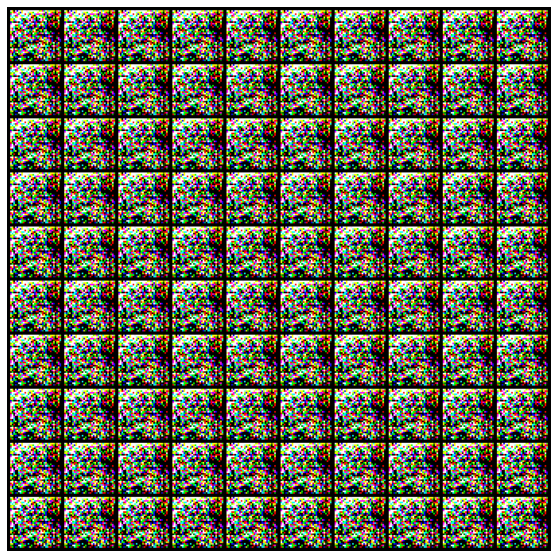

In [ ]:
with torch.no_grad():
    gen_data = generator(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))

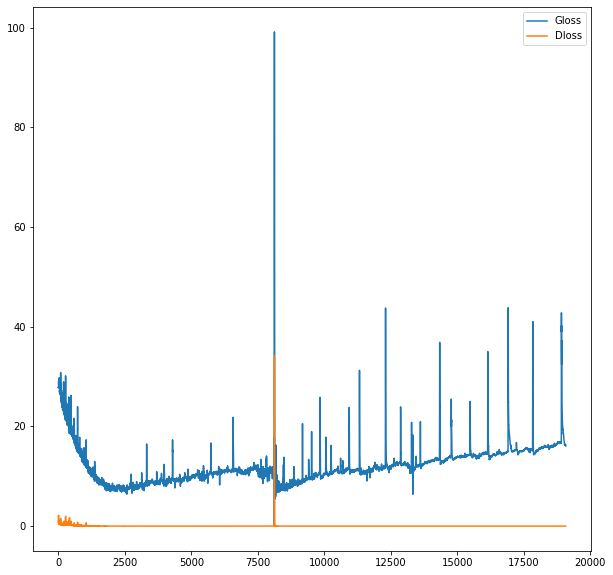

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(G_losses, label = 'Gloss')
plt.plot(D_losses, label = 'Dloss')
plt.legend()
plt.show()

In [ ]:
fixed_noise_ = torch.randn(100, 128, 1, 1, device=device)

con2 = (((torch.arange(10, device=device).repeat(10))/9 - 1/2)*4).view(100, 1, 1, 1)
con1 = torch.zeros(100, 1, 1, 1, device=device)
x_ = np.arange(10).repeat(10)
dis_ = torch.zeros(100, 1, 10, device=device)
dis_[torch.arange(100), 0, x_] = 1 
dis_ = dis_.view(100, -1, 1, 1)
fixed_noise_ = torch.cat((fixed_noise_, dis_, con1, con2), dim=1)